In [89]:
import torch
import torch.nn as nn
import json
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import os

import utils

Подготовка датасета

In [90]:
TRAIN_DATA_DIR = 'data/train_images/train_images'
TEST_DATA_DIR = 'data/test_images/test_images'

In [91]:
with open('data/usdc_train.json', 'r') as file:
    train_data = json.load(file)

In [92]:
classes_dict = {}
for sample in train_data['categories']:
    classes_dict[sample['id']-1] = sample['name']
del classes_dict[-1]
classes_dict 

{0: 'biker',
 1: 'car',
 2: 'pedestrian',
 3: 'trafficLight',
 4: 'trafficLight-Green',
 5: 'trafficLight-GreenLeft',
 6: 'trafficLight-Red',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-Yellow',
 9: 'trafficLight-YellowLeft',
 10: 'truck'}

In [93]:
annotations_df = pd.DataFrame(train_data['annotations'])
annotations_df = annotations_df.drop(columns=['id', 'segmentation', 'iscrowd', 'confidence', 'score'])
annotations_df.head()

,image_id,category_id,bbox,area
0,5,2,"[196, 234, 20.266666666666666, 24.74666666666667]",501.532444
1,5,2,"[247, 236, 16.53333333333333, 24.74666666666667]",409.144889
2,5,2,"[265, 234, 20.8, 23.893333333333334]",496.981333
3,5,2,"[267, 237, 15.466666666666667, 17.066666666666...",263.964444
4,5,2,"[305, 233, 78.93333333333334, 75.94666666666667]",5994.723556


In [94]:
annotations_df['category_id'].unique()

array([ 2,  8,  1,  7, 11,  3,  4,  5,  9,  6, 10])

In [95]:
annotations_df['category_id'] = annotations_df['category_id'].apply(lambda x: x - 1)

In [96]:
images_df = pd.DataFrame(train_data['images'])
images_df = images_df.drop(columns=['license', 'height', 'width', 'date_captured'])
images_df = images_df.rename(columns={'id' : 'image_id'})
images_df.head()

,image_id,file_name
0,5,1478020898717725646_jpg.rf.68EjFVQdDWrB0SW6qVl...
1,14,1478020650710690845_jpg.rf.68NUjFyrbU9Nsyt3ika...
2,22,1478898975867837103_jpg.rf.6847BekYxQ4SlhtvjlE...
3,57,1478895940606118436_jpg.rf.68xNq7HL27EKmRnrGgp...
4,58,1478896447910420804_jpg.rf.68xeyVz6sbVFpLVku7W...


In [97]:
train_annotations = utils.create_dataset(images_df, annotations_df)

In [98]:
class DetectionDataset(Dataset):
    def __init__(self, annotations: dict, img_dir: str, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        sample = self.annotations[idx]
        img_path = os.path.join(TRAIN_DATA_DIR, sample['file_name'])
        
        image = Image.open(img_path)
        
        bboxes = []
        labels = []
        for obj in sample['annotations']:
            bboxes.append(obj['bbox'])
            labels.append(obj['class'])
            
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        if self.transform:
            image = self.transform(image)
            
        return image, {'bboxes' : bboxes, 'labels' : labels}

In [99]:
train_dataset = DetectionDataset(train_annotations, TRAIN_DATA_DIR)

{'bboxes': tensor([[ 43.0000, 263.0000,  65.0667,  63.1467],
        [147.0000, 188.0000, 363.2000, 192.8533]]), 'labels': tensor([ 1, 10])}


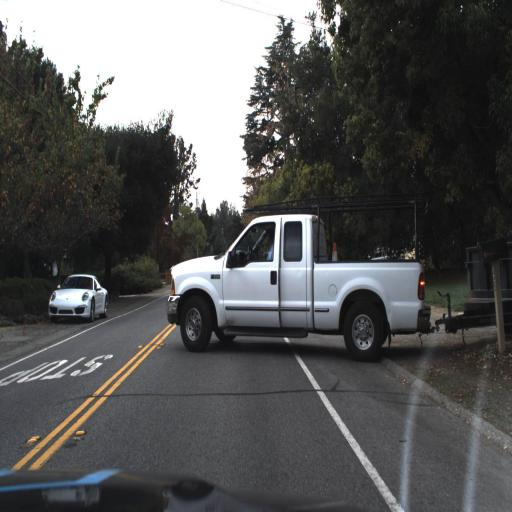

In [112]:
print(train_dataset[2323][1])
train_dataset[2323][0]

Добавление различных типов нормализаций